In [1]:
from tensorflow.python.client import device_lib

print("Available devices:")
for device in device_lib.list_local_devices():
    if device.device_type == "GPU":
        print(f"Name: {device.name}, Type: {device.device_type}, Memory: {device.memory_limit / 1024**3:.2f} GB")




Available devices:
Name: /device:GPU:0, Type: GPU, Memory: 2.08 GB


<h1>Load Dataset</h1>

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras import utils,layers
from keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import time

In [78]:
img_height = 224
img_width = 224
num_classes = 4
batch_size = 8

In [68]:
data_train = utils.image_dataset_from_directory(
    'archive/train',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','2','3'],
    color_mode='rgb',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 4960 files belonging to 4 classes.


In [69]:
data_val = utils.image_dataset_from_directory(
    'archive/val',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','2','3'],
    color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 826 files belonging to 4 classes.


In [70]:
AUTOTUNE = tf.data.AUTOTUNE

train = data_train.cache().prefetch(buffer_size=AUTOTUNE)
val = data_val.cache().prefetch(buffer_size=AUTOTUNE)

In [71]:
for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 224, 224, 3)
(8,)


<h1>Visualization of Samples</h1>

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

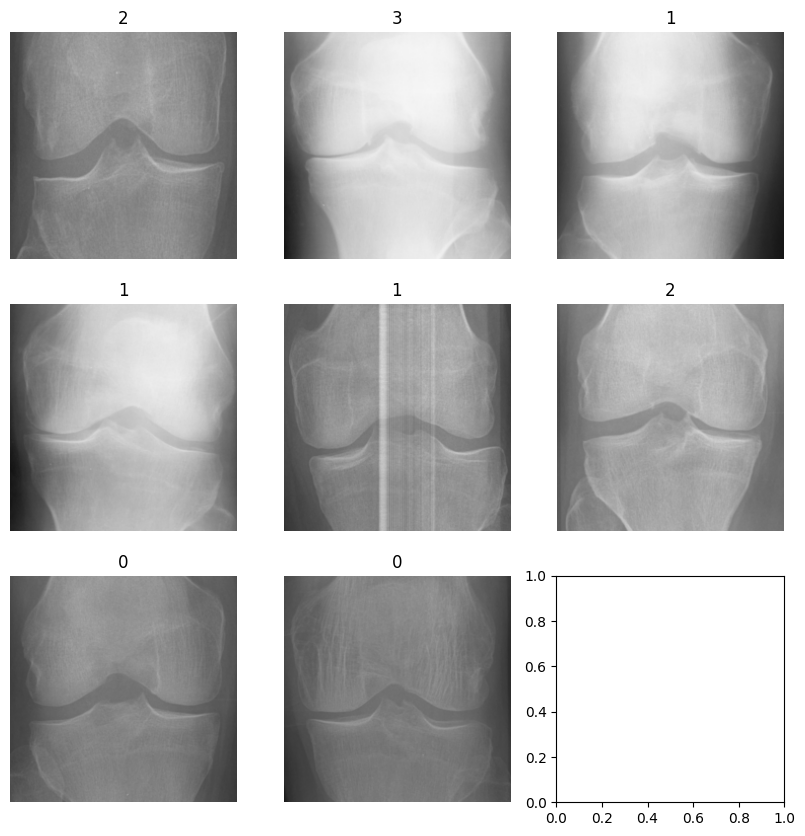

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(6):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(data_train.class_names[labels[i]])
    plt.axis("off")

<h1>Neural Network Architecture</h1>

In [76]:
img_shape=(img_height, img_width, 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(num_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [77]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_16 (Rescaling)       (None, 224, 224, 3)  0           ['input_9[0][0]']                
                                                                                                  
 normalization_8 (Normalization  (None, 224, 224, 3)  7          ['rescaling_16[0][0]']           
 )                                                                                                
                                                                                            

In [85]:
epochs = 10
history = model.fit(val, validation_data=train, epochs=epochs, verbose=1)

Epoch 1/10
104/104 [==============================] - 40s 339ms/step - loss: 1.2469 - accuracy: 0.5569 - val_loss: 0.9243 - val_accuracy: 0.6585
Epoch 2/10
104/104 [==============================] - 31s 301ms/step - loss: 0.7925 - accuracy: 0.7579 - val_loss: 0.8143 - val_accuracy: 0.7365
Epoch 3/10
104/104 [==============================] - 32s 309ms/step - loss: 0.5639 - accuracy: 0.8850 - val_loss: 0.8006 - val_accuracy: 0.7601
Epoch 4/10
104/104 [==============================] - 32s 310ms/step - loss: 0.4176 - accuracy: 0.9479 - val_loss: 0.9242 - val_accuracy: 0.7530
Epoch 5/10
104/104 [==============================] - 32s 314ms/step - loss: 0.3714 - accuracy: 0.9588 - val_loss: 0.7508 - val_accuracy: 0.7897
Epoch 6/10
104/104 [==============================] - 33s 316ms/step - loss: 0.3188 - accuracy: 0.9758 - val_loss: 0.7864 - val_accuracy: 0.7837
Epoch 7/10
104/104 [==============================] - 34s 327ms/step - loss: 0.2867 - accuracy: 0.9867 - val_loss: 0.7950 - val_ac

In [81]:
model.keras.save('EfficientNetB3-56val.h5')

AttributeError: 'Functional' object has no attribute 'keras'

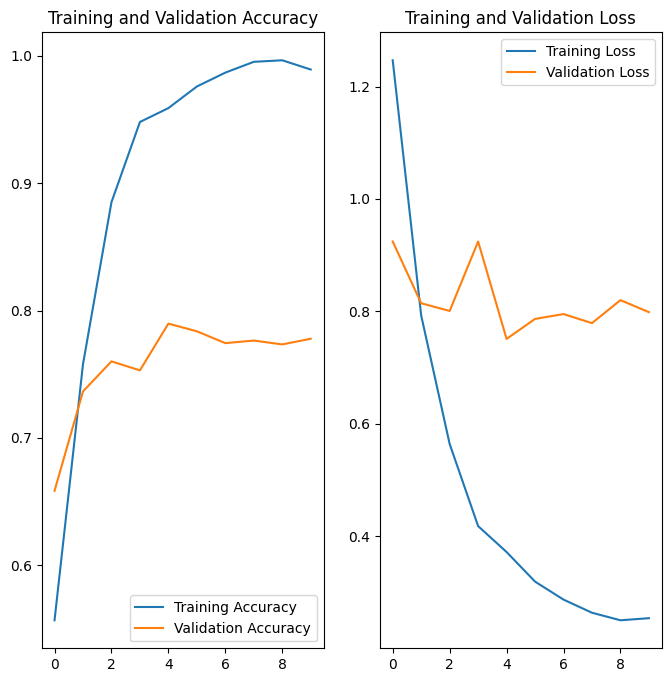

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
tf.saved_model.save(model, "my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.